### Abstract
In this blog post, we will analyze the Palmer Penguins dataset, which was collected by Dr. Kristen Gorman and the Palmer Station in Antarctica. It contains various types of quantitative and qualitative data about the penguins observed by Gorman et al. To analyze this data, we will train a machine learning model on it, and find the best combination of features to train that model on. We will then test our model against the test dataset and determine its usability. The model we will use is a Logistic Regression model, which uses linear equations to create boundaries and categorizes based on those boundaries.

### Setup
First we can load in the data as a Pandas dataframe.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

We can then look at the dataframe we have made:

In [5]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


We can shorten the species of the penguins to just the first word, which will make it easier to catalogue them.

In [6]:
train["Species"] = train["Species"].str.split().str.get(0)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


### Figure Creation
Now that we've preprocessed the data a little bit, we can create a few plots to get an idea of what this data means. Below, we use seaborn to create a scatterplot and a bar plot.

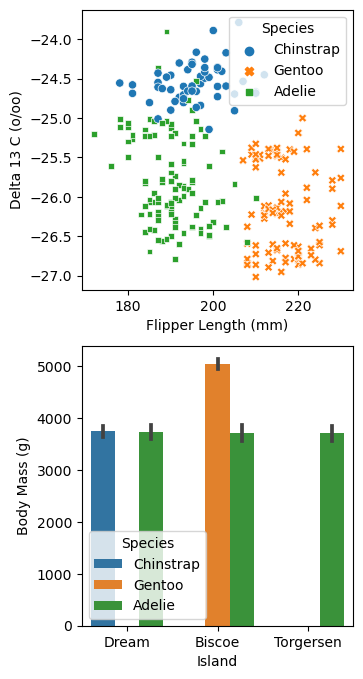

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (3.5, 8))

p1 = sns.scatterplot(train, x = "Flipper Length (mm)", y = 'Delta 13 C (o/oo)', hue = "Species", style = "Species", ax = ax[0])
p2 = sns.barplot(train, x = "Island", y = "Body Mass (g)", hue = 'Species')

**Figure 1:** A scatterplot showing flipper length against Delta 13 C for three species of penguins. We can see that there is some correlation, but at the edges the species overlap a bit.

**Figure 2:** A bar graph showing body mass for each species on each island. Torgerson only contains Adelie, Dream has pretty equal body masses for Adelie and Chinstrap, and Biscoe has Gentoo penguins at a much larger size than the other penguins.

From these figures, we can tell that flipper length differentiates Adelie and Gentoo penguins, and that Delta 13 C differentiates Adelie and Chinstrap penguins. However, we do get some overlap between Chinstrap and Adelie that would reduce model accuracy. The second plot shows that only Adelie penguins were observed on Torgerson, Gentoos were only observed on Biscoe, and Chinstraps were only observed on Dream. Although Adelie penguins are found on all three islands, there is enough separation that we can assume that it would be an informative factor to include.

Next, let's group the data into an informative table.

In [21]:
train.groupby("Species")["Flipper Length (mm)"].mean()

Species
Adelie       190.084034
Chinstrap    196.000000
Gentoo       216.752577
Name: Flipper Length (mm), dtype: float64

Here we can see that Gentoo penguins have much longer flippers on average than the other species! Chinstrap has more than Adelie, but the difference is not as significant. This could indicate that flipper length will be a useful feature for our model.

Now that we've seen some of the data plotted out, we can continue the preprocessing step. The predict() function below drops unnecessary columns, rows/columns with null values, assigns species to integers rather than strings, and then splits the species into a separate data structure, y.

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

x_train, y_train = prepare_data(train)
x_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,True,False,False,True,False,True,False,True
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,False,False,True,True,True,False,True,False
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,False,True,False,True,False,True,True,False
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,False,False,True,True,False,True,True,False


### Deciding on attributes
We now need to pick the attributes that will yield the best prediction accuracy. To do this, we will use an exhaustive approach, where we check the accuracy of a linear regression model trained on all possible feature combinations. In the code below, we loop through all possible combinations of qualitative and quantitative attributes. In each iteration, we train a model on the different combinations of features, and we compile an array of all the combinations (along with their scores and the model that was trained on them).

In [10]:
#| output: false
from itertools import combinations
from sklearn.linear_model import LogisticRegression

all_qual_cols = ["Clutch Completion", "Island", "Sex", "Stage"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
scores = []
combo_array = []


for qual in all_qual_cols:
  qual_cols = [col for col in x_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols                               #<1>
    combo_array.append(cols)                                    #<1>
    LR = LogisticRegression()                                   #<2>
    LR.fit(x_train[cols], y_train)                              #<2>
    new_score = LR.score(x_train[cols], y_train)                #<3>
    scores.append((cols, new_score, LR))                        #<4>


/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

1. Gather the features for this iteration
2. Create the Logistic Regression model and train it on our selected features
3. Score the trained model
4. Add the features, score, and model as a tuple to the array of our catalogued models

In [11]:
from operator import itemgetter
best_combo = max(scores, key = itemgetter(1))
print(best_combo)
best_attrs = best_combo[0]
best_score = best_combo[1]
best_lr = best_combo[2]

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], 0.99609375, LogisticRegression())


It looks like Island, Culmen Length, and Culmen Depth are our most helpful attributes.

Next, we need to prepare our test data in the same way that we prepared our training data.

In [12]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)
x_test, y_test = prepare_data(test)

We can then score our trained model on its performance with the test data.

In [13]:
best_lr.score(x_test[best_attrs], y_test)

1.0

Great! We have 100% accuracy on the testing data. Now for some more plotting...

### Plotting the Category Regions

Using Matplotlib, we can display the categories on a plot as colored regions. This allows us to visualize how the test points are categorized, and we can get a visual representation of the accuracy of the model.

In [14]:
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Gentoo", "Chinstrap", "Adelie"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

We are going to look at both the training data and the testing data, split up by the qualitative factor (the islands).

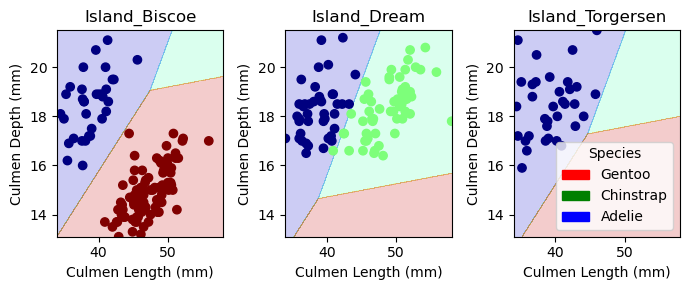

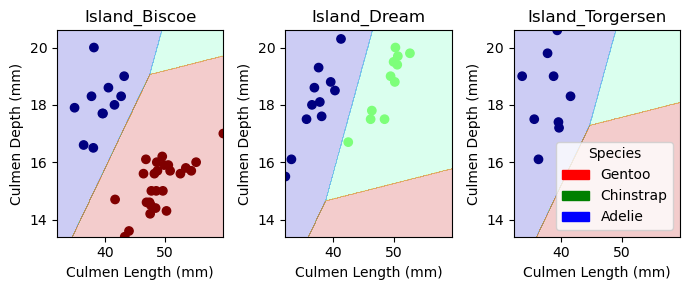

In [15]:
plot_regions(best_lr, x_train[best_attrs], y_train)
plot_regions(best_lr, x_test[best_attrs], y_test)

We can see that the model had no trouble at all with the test data--all the points were clearly within their respective categories on the plot. To continue to test our model against unseen data, we can split up the training data to cross-validate. scikit-learn has a function for this, and it will test our Logistic Regression model against different subsets of the training model.

Cross-validating...

In [16]:
#| output: false
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(best_lr, x_train[best_attrs], y_train, cv=5)
print(cv_scores_LR.mean())
cv_scores_LR

0.9961538461538462


/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

array([0.98076923, 1.        , 1.        , 1.        , 1.        ])

Our model did very well on the cross-validation in addition to the training data, with an average score of 99.6%. Another way we can visualize its performance is to create a confusion matrix, which shows us specifically what the model predicted in terms of classification. We will do this with our test data.

Confusion matrix:

In [17]:
from sklearn.metrics import confusion_matrix

y_test_pred = best_lr.predict(x_test[best_attrs])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

More intuitive formatting:

In [18]:
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

There were 31 Adelie penguin(s) who were classified as Adelie.
There were 0 Adelie penguin(s) who were classified as Chinstrap.
There were 0 Adelie penguin(s) who were classified as Gentoo.
There were 0 Chinstrap penguin(s) who were classified as Adelie.
There were 11 Chinstrap penguin(s) who were classified as Chinstrap.
There were 0 Chinstrap penguin(s) who were classified as Gentoo.
There were 0 Gentoo penguin(s) who were classified as Adelie.
There were 0 Gentoo penguin(s) who were classified as Chinstrap.
There were 26 Gentoo penguin(s) who were classified as Gentoo.


Since the model was 100% correct on the testing data, it is hard to comment on where it could go wrong. However, I predict that false positives for Adelie could occur, since Adelie penguins are found on all three islands. Additionally, the training data included a few penguins who were Chinstraps that were on the border of the Chinstrap and Adelie classifications in the above regions plot.

### Discussion
In this blog post, we used a Logistic Regression model to classify penguins from the Palmer Penguins dataset. We found that the most important features were the island they were observed on and their culmen dimensions. In general, the model was successful in categorizing the section of the data that we put aside for testing, and it performed well for being trained on only a few features. I am curious if adding more features would improve the accuracy of the model, or if it would introduce overfitting to the model and would become too specific. 